In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.ode_rnn import ODE_RNN
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
# from latent_rnn import create_LatentODE_model

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [9]:
obsrv_std = torch.Tensor([0.1]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
latent_dim = 25

In [10]:
obsrv_std = torch.Tensor([0.1]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
gru_units = 40
n_ode_gru_dims = latent_dim
				
ode_func_net = utils.create_net(n_ode_gru_dims, n_ode_gru_dims, 
    n_layers = 2, n_units = 50, nonlinear = nn.Tanh)

rec_ode_func = ODEFunc(
    input_dim = input_dim, 
    latent_dim = n_ode_gru_dims,
    ode_func_net = ode_func_net,
    device = device).to(device)

z0_diffeq_solver = DiffeqSolver(input_dim, rec_ode_func, "dopri5", latent_dim, 
    odeint_rtol = 1e-3, odeint_atol = 1e-4, device = device)

model = ODE_RNN(input_dim=input_dim, latent_dim=latent_dim, 
            n_gru_units = 50, n_units = 50, device = device, 
			z0_diffeq_solver = z0_diffeq_solver,
			concat_mask = True, obsrv_std = obsrv_std,
			use_binary_classif = False,
			classif_per_tp = False,
			n_labels = 1,
			train_classif_w_reconstr = False
			).to(device)

In [11]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state_ucr.pth.tar', map_location=torch.device('cpu'))

In [12]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [13]:
model.eval()

ODE_RNN(
  (ode_gru): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=52, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=25, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=52, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=25, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=52, out_features=50, bias=True)
        (1): Tanh()
        (2): Linear(in_features=50, out_features=50, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=25, out_features=50, bias=True)
          (1): Tanh()
          (2): Linear(in_features=50, out_features=50, bias=True)
          (3): Tanh()
          (4): Linear(in_features

In [34]:
loader = torch.load('ucr_train.pt')

## Inference

In [15]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
rec_stds = []
samples = []
for batch in tqdm(loader):
    observed = batch['observed_data'].to(device)
    true = batch['data_to_predict'].to(device)
    truths.extend([x for x in true])
    mask = batch['observed_mask'].to(device)
    mask_pred = batch['mask_predicted_data']#.to(device)
#     mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
#     if not mask_pred:
#         mask_pred = torch.ones(true.shape)
    mask_pred = mask_pred.to(device)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp'].to(device)
#     truth_time_steps = t[mask.nonzero()]
#     ts.append(t.detach().cpu())
    z_u, z_std = model.ode_gru.forward(x, t)
    rec = model.get_reconstruction(
        time_steps_to_predict=t, data=observed, truth_time_steps=t, mask=mask, n_traj_samples=20)[0].detach().cpu().squeeze()
#     rec_u = rec.mean(dim=0)
#     rec_std = rec.std(dim=0)
    recs.extend([x for x in rec])
#     rec_stds.extend([x for x in rec_std])
#     z_u = z_u.squeeze()
    z_u = z_u.detach().cpu()
    z_std = z_std.detach().cpu()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


In [35]:
ix = 100

In [36]:
# y = samples[ix].detach().cpu().numpy().reshape(1,-1)
y = recs[ix].numpy().reshape(1,-1)
x = t.detach().cpu().numpy().reshape(1,-1)
y_true = truths[ix].detach().cpu().numpy().reshape(1,-1)

IndexError: list index out of range

In [23]:
d_predict = np.concatenate([x, y], axis=0).T
d_true = np.concatenate([x, y_true], axis=0).T

In [24]:
df_predict = pd.DataFrame(d_predict, columns = ['t', 'value'])
df_predict['type'] = 'prediction'
df_truth = pd.DataFrame(d_true, columns = ['t', 'value'])
df_truth['type'] = 'truth'
df = pd.concat([df_predict, df_truth], 0)

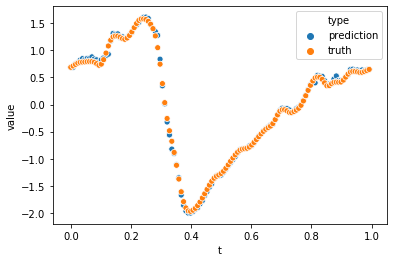

In [25]:
sns.scatterplot(x='t', y='value', data=df, hue='type')

In [26]:
break

SyntaxError: 'break' outside loop (<ipython-input-26-6aaf1f276005>, line 4)

### Plot Multiple

In [27]:
loader = torch.load('ucr_train.pt')

In [28]:
batch = next(iter(loader))

In [29]:
ix = 3

In [30]:
observed = batch['observed_data'][ix].unsqueeze(0).to(device)
true = batch['data_to_predict'][ix].unsqueeze(0).to(device)
mask = batch['observed_mask'][ix].unsqueeze(0).to(device)
t = batch['observed_tp'].to(device)

In [31]:
observed.shape

torch.Size([1, 128, 1])

In [32]:
rec = model.get_reconstruction(
    time_steps_to_predict=t, 
    truth=observed, 
    truth_time_steps=t, 
    mask=mask, 
    n_traj_samples=50)[0].detach().cpu().squeeze()

TypeError: get_reconstruction() got an unexpected keyword argument 'truth'

In [ ]:
u = rec.mean(dim=0).detach().cpu().numpy()
recs = rec.detach().cpu().numpy()
t = t.detach().cpu().numpy()

In [ ]:
plt.style.use('seaborn-darkgrid')
# my_dpi=48
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 8,
        }

In [ ]:
# plt.figure(figsize=(1.5*480/my_dpi, 480/my_dpi), dpi=my_dpi)
for r in recs:
    plt.plot(t, r, marker='', color='grey', linewidth=1, alpha=0.4)
plt.plot(t, u, marker='', color='orange', linewidth=2, alpha=1)
plt.xlabel("Time", fontdict=font)
plt.ylabel("Magnitude", fontdict=font)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    right=False, 
    left=False)